# Init

In [3]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing as pp, visualization
import modules.data_generation as data_generation
from modules.data_generation import DataGenerator
import matplotlib.pyplot as plt

logger = logging.getLogger("dataGenNb")


## Generate data 

Data should be in an appropriate format and filtered before when we load it here. It does not have to be scaled. 

In [4]:
dg = DataGenerator(natoms=30, nclusters=3, nframes_per_cluster=1500, 
                   noise_level=1e-2, 
                   displacement=5, 
                   cluster_generation_method=data_generation.constant_displacement)
dg.generate_clusters()
feature_to_resids = dg.feature_to_resids()
data, labels = dg.generate_frames()
cluster_indices = labels.argmax(axis=1)
feature_to_resids = None
logger.info("Generated data of shape %s and %s clusters", data.shape, labels.shape[1])

2018-11-05 19:11:36 dataGenNb-INFO: Generated data of shape (4500, 435) and 3 clusters


## Define the different methods to use

Every method is encapsulated in a so called FeatureExtractor class which all follow the same interface

In [5]:
n_iterations, n_splits = 2, 1
feature_extractors = [
    #fe.MlpFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations, hidden_layer_sizes=(100,), training_max_iter=10000, activation="relu"), #, solver="sgd"),
    fe.RbmFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations, n_components=int(data.shape[1]/10)),
    #fe.ElmFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations, n_nodes=2000),
    fe.KLFeatureExtractor(data, labels, n_splits=n_splits),
    #fe.PCAFeatureExtractor(data, labels, n_splits=n_splits),
    #fe.RandomForestFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


2018-11-05 19:11:36 dataGenNb-INFO: Done. using 2 feature extractors


# Run the relevance analysis

In [6]:
results = []
for extractor in feature_extractors:
    extractor.error_limit = 99
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features(filter_results=True)
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance, errors))
logger.info("Done")


2018-11-05 19:11:36 dataGenNb-INFO: Computing relevance for extractors RB
2018-11-05 19:11:36 Extracting feature-INFO: Using all data in training and validation sets
2018-11-05 19:11:36 Extracting feature-DEBUG: Iteration 1 of 2
2018-11-05 19:11:38 Extracting feature-DEBUG: Computing feature importance on all data.
2018-11-05 19:11:40 Extracting feature-DEBUG: Iteration 2 of 2
2018-11-05 19:11:42 Extracting feature-DEBUG: Computing feature importance on all data.
2018-11-05 19:11:44 dataGenNb-INFO: Computing relevance for extractors KL
2018-11-05 19:11:44 Extracting feature-INFO: Using all data in training and validation sets
2018-11-05 19:11:44 Extracting feature-DEBUG: Iteration 1 of 1
2018-11-05 19:11:44 Extracting feature-DEBUG: Computing feature importance on all data.
2018-11-05 19:11:44 dataGenNb-INFO: Done


# Postprocess results to get average features

In [7]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = pp.PostProcessor(extractor, feature_importance, std_feature_importance, errors, cluster_indices,
                                     working_dir=None, feature_to_resids=feature_to_resids, 
                                     predefined_relevant_residues=dg.moved_atoms)
    p.average()
    postprocessors.append(p)

logger.info("Done")


2018-11-05 19:11:44 postprocessing-DEBUG: Not possible to compute importance per cluster
2018-11-05 19:11:44 dataGenNb-INFO: Done


# Evaluate results

## Find top ranked residues

2018-11-05 19:12:14 dataGenNb-INFO: Actual atoms moved: [6, 11, 17].
(Cluster generation method constant_displacement. Noise level=0.01, displacement=5. frames/cluster=1500)
2018-11-05 19:12:14 dataGenNb-INFO: Moved atoms for RB: [6, 11, 17]
2018-11-05 19:12:14 dataGenNb-INFO: Moved atoms for KL: [6, 11, 17]


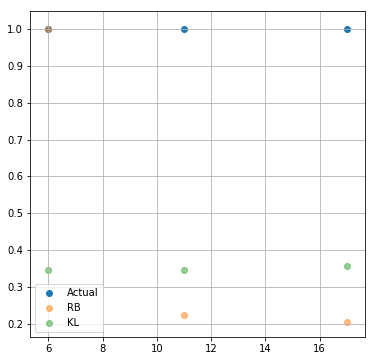

In [11]:
logger.info("Actual atoms moved: %s.\n(Cluster generation method %s. Noise level=%s, displacement=%s. frames/cluster=%s)", 
            sorted(dg.moved_atoms), 
            dg.cluster_generation_method, dg.noise_level, dg.displacement, dg.nframes_per_cluster)
def show_moved_atoms(dg, postprocessors):
    plt.figure(figsize=(6,6))
    yvalues = np.zeros(dg.moved_atoms.shape) + 1
    plt.scatter(dg.moved_atoms, yvalues, label="Actual")
    for pp in postprocessors:
        #Get most relevant atoms, not that they are not sorted
        label=pp.extractor.name
        moved_atoms = np.argpartition(pp.importance_per_residue, -dg.nclusters)[-dg.nclusters:]
        importance_moved_atoms = pp.importance_per_residue[moved_atoms]
        plt.scatter(moved_atoms, importance_moved_atoms, label=label, alpha=0.5)
        logger.info("Moved atoms for %s: %s", label, sorted(moved_atoms) )
    plt.legend()
    plt.grid()
    plt.show()
    
show_moved_atoms(dg, postprocessors)    

## Visualize them

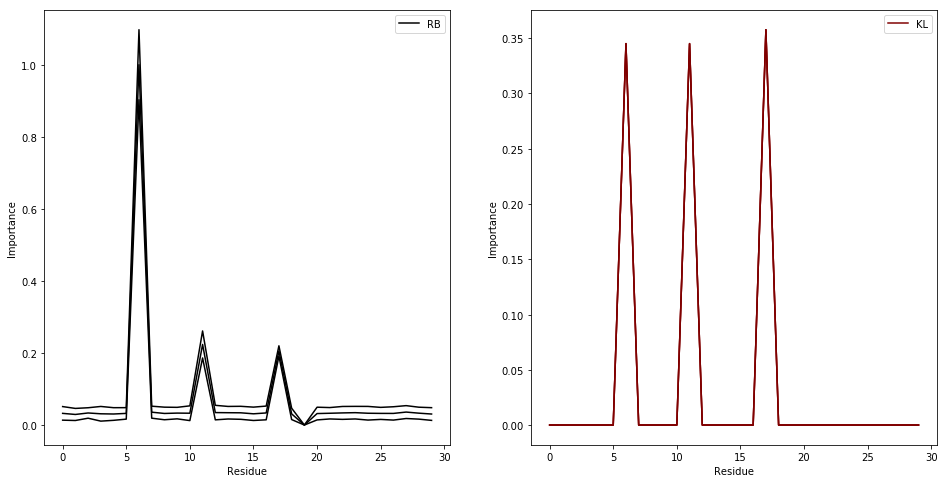

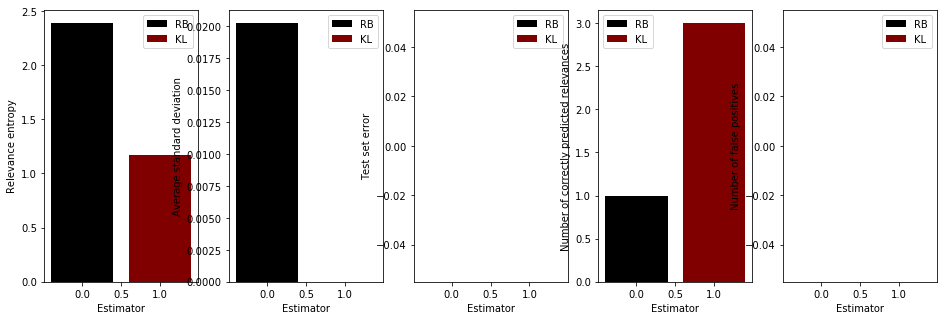

2018-11-05 19:11:52 dataGenNb-INFO: Done


In [9]:
visualization.visualize(postprocessors, show_performance=True)
logger.info("Done")